### RNA-Charakterisierung - NaCl-Titration 

2023-05-22

In [1]:
import b_lab_functions as blab
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import optimize

In [2]:
newdata = blab.read_ID5_data('2023-05-22_NaCl-titration_VS.txt')

Please enter Emission Wavelengths (3) without comma:
 595 670 670
Please enter Excitation Wavelengths (3) without comma:
 530 530 630


Using ID5-function to read ID5-files...
Experiment 'FRET_21°C': emission wavelengths 595 nm and 630nm, excitation wavelength: 530nm
Experiment 'FRET_23°C': emission wavelengths 595 nm and 630nm, excitation wavelength: 530nm
Experiment 'FRET_25°C': emission wavelengths 595 nm and 630nm, excitation wavelength: 530nm
Experiment 'FRET_27°C': emission wavelengths 595 nm and 630nm, excitation wavelength: 530nm
Experiment 'FRET_29°C': emission wavelengths 595 nm and 630nm, excitation wavelength: 530nm
Experiment 'FRET_31°C': emission wavelengths 595 nm and 630nm, excitation wavelength: 530nm
Experiment 'FRET_33°C': emission wavelengths 595 nm and 630nm, excitation wavelength: 530nm
Experiment 'FRET_35°C': emission wavelengths 595 nm and 630nm, excitation wavelength: 530nm
Experiment 'FRET_37°C': emission wavelengths 595 nm and 630nm, excitation wavelength: 530nm
Experiment 'FRET_39°C': emission wavelengths 595 nm and 630nm, excitation wavelength: 530nm
Experiment 'FRET_41°C': emission wavelen

### Mittelwerte von Blanks

In [3]:
# alle blanks von allen Wells bei jeder temperatur in einem df
mean_blanks = []
for i, name in enumerate(newdata.keys()):
    if "Measurement" in name and "FRET" in name:
        blank = newdata[name][newdata[name]["wellnumber"].str.contains("1") == True] # geht nicht mehr mit 10, 11, 12
        mean_blanks.append(blank)
    
blank_df = pd.concat(mean_blanks)
blank_df

,excitation wavelength (nm),emission wavelength (nm),temperature (°C),wellnumber,value (x)
0,530,595,21.5,A1,3910
9,530,595,21.5,B1,2925
18,530,595,21.5,C1,3509
27,530,595,21.5,D1,4500
36,530,595,21.5,E1,4284
...,...,...,...,...,...
171,630,670,65.0,D1,4690
180,630,670,65.0,E1,4808
189,630,670,65.0,F1,3989
198,630,670,65.0,G1,3855


In [4]:
#blank_df

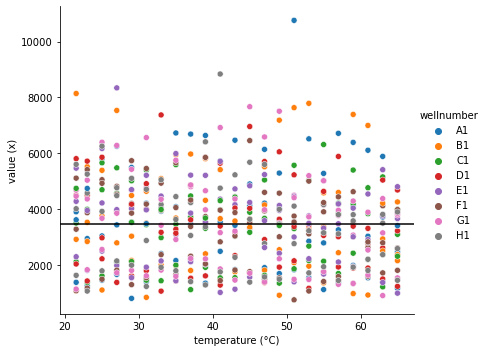

In [5]:
sns.relplot(data=blank_df, x="temperature (°C)", y="value (x)", hue='wellnumber', legend=True, aspect=1.2, markers='x')
plt.axhline(y=3477.1485507246375, color='black', linestyle='-')
plt.savefig("2023_05_22_RNA_NaCl_all_blanks.png", dpi=600, bbox_inches="tight")
plt.show()

In [6]:
#Mittelwert über alle blank Werte aus allen Messungen bei jeder Temperatur aus der ersten Durchführung
mean_blank = blank_df.iloc[:,4].mean()
mean_blank

3477.1485507246375

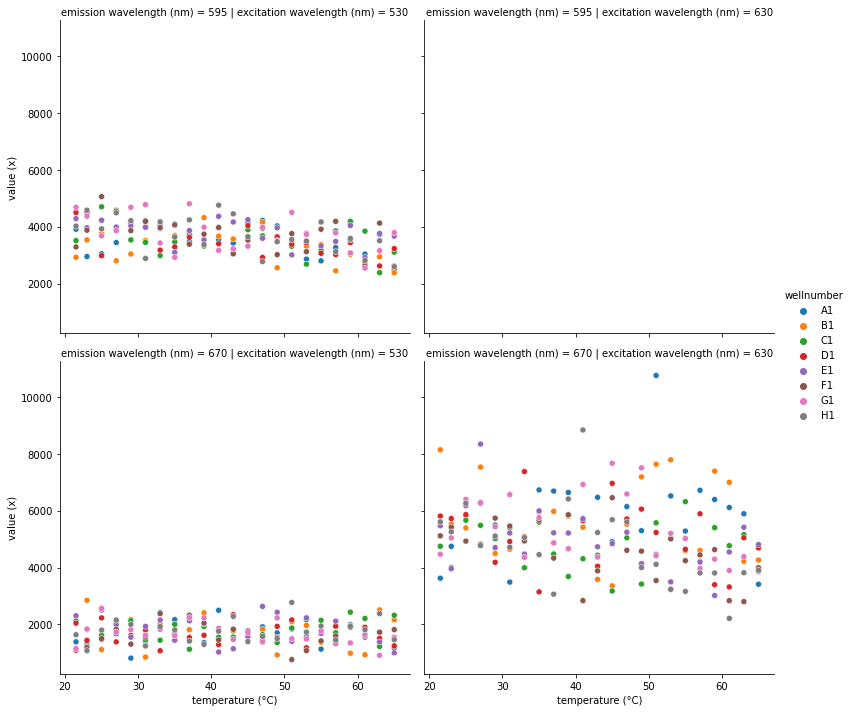

In [7]:
sns.relplot(data=blank_df, x="temperature (°C)", y="value (x)", hue='wellnumber', col="excitation wavelength (nm)", \
            row="emission wavelength (nm)", legend=True, aspect=1.1, markers='x')
plt.savefig("2023_05_22_RNA_NaCl_blanks.png", dpi=600, bbox_inches="tight")
plt.show()

##### Der Mittelwert des blanks von 3246.6420454545455 muss von den Messwerten als bg-Korrektur abgezogen werden

In [8]:
for i, name in enumerate(newdata.keys()):
    if "Measurement" in name and "FRET" in name:
        newdata[name]["bg_corr"] = newdata[name]["value (x)"]-mean_blank

In [9]:
#newdata["Measurement14_FRET_41°C"]

### Konzentrationen und Konstrukte zum DataFrame hinzufügen

In [10]:
# dictionary fuer Konzentrationen im Well --> es werden die zugegebenen Konzentrationen angegeben --> K(I) background durch HEPES beachten
conc_well = {"A2":0,
             "B2":1,
             "C2":2.5,
             "D2":5,
             "E2":7.5,
             "F2":10,
             "G2":12.5,
             "H2":25,
             "A3":50,
             "B3":75,
             "C3":100,
             "D3":500,
             "A4":0,
             "B4":1,
             "C4":2.5,
             "D4":5,
             "E4":7.5,
             "F4":10,
             "G4":12.5,
             "H4":25,
             "A5":50,
             "B5":75,
             "C5":100,
             "D5":500,
             "A6":0,
             "B6":1,
             "C6":2.5,
             "D6":5,
             "E6":7.5,
             "F6":10,
             "G6":12.5,
             "H6":25,
             "A7":50,
             "B7":75,
             "C7":100,
             "D7":500,
             "A8":0,
             "B8":1,
             "C8":2.5,
             "D8":5,
             "E8":7.5,
             "F8":10,
             "G8":12.5,
             "H8":25,
             "A9":50,
             "B9":75,
             "C9":100,
             "D9":500
}

In [11]:
def add_new_column(dataframe, value_column_name, dictionary, new_column_name):
    """
    Adds a new column to a pandas DataFrame based on a value in a specified column, using a dictionary to map the value to
    a new value for the new column.

    Parameters:
    dataframe (pandas.DataFrame): The DataFrame to modify.
    value_column_name (str): The name of the column to use as the source for the value to map to a new value.
    dictionary (dict): The dictionary to use to map the value to a new value for the new column.
    new_column_name (str): The name of the new column to add to the DataFrame.

    Returns:
    pandas.DataFrame: The modified DataFrame with the new column added.
    """
    new_column_values = []

    for index, row in dataframe.iterrows():
        value = row[value_column_name]

        if value in dictionary:
            new_value = dictionary[value]
        else:
            new_value = None

        new_column_values.append(new_value)

    dataframe[new_column_name] = new_column_values

    return dataframe

In [12]:
#test = add_new_column(newdata["Measurement14_FRET_45°C"], "wellnumber", conc_well, "concentration (mM)")
#test

In [13]:
FRET_data = []
for i, name in enumerate(newdata.keys()):
    if "Measurement" in name and "FRET" in name:
        df_conc = add_new_column(newdata[name], "wellnumber", conc_well, "concentration (mM)")
        FRET_data.append(df_conc)
df_FRET = pd.concat(FRET_data)
df_FRET

,excitation wavelength (nm),emission wavelength (nm),temperature (°C),wellnumber,value (x),bg_corr,concentration (mM)
0,530,595,21.5,A1,3910,4.328514e+02,NaN
1,530,595,21.5,A2,670661,6.671839e+05,0.0
2,530,595,21.5,A3,548059,5.445819e+05,50.0
3,530,595,21.5,A4,1061004,1.057527e+06,0.0
4,530,595,21.5,A5,1016300,1.012823e+06,50.0
...,...,...,...,...,...,...,...
211,630,670,65.0,H5,6297,2.819851e+03,NaN
212,630,670,65.0,H6,2069970,2.066493e+06,25.0
213,630,670,65.0,H7,8704,5.226851e+03,NaN
214,630,670,65.0,H8,1674036,1.670559e+06,25.0


In [14]:
df_FRET = df_FRET[df_FRET['concentration (mM)'].notna()] # NaN entfernt
print(df_FRET["wellnumber"].unique())

['A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7'
 'B8' 'B9' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'D2' 'D3' 'D4' 'D5'
 'D6' 'D7' 'D8' 'D9' 'E2' 'E4' 'E6' 'E8' 'F2' 'F4' 'F6' 'F8' 'G2' 'G4'
 'G6' 'G8' 'H2' 'H4' 'H6' 'H8']


In [15]:
# dictionary fuer Konstrukt im Well --> hier geht nicht mit Buchstaben zu arbeiten
construct_well = {"A2":1.1,
             "B2":1.1,
             "C2":1.1,
             "D2":1.1,
             "E2":1.1,
             "F2":1.1,
             "G2":1.1,
             "H2":1.1,
             "A3":1.1,
             "B3":1.1,
             "C3":1.1,
             "D3":1.1,
             "A4":1.2,
             "B4":1.2,
             "C4":1.2,
             "D4":1.2,
             "E4":1.2,
             "F4":1.2,
             "G4":1.2,
             "H4":1.2,
             "A5":1.2,
             "B5":1.2,
             "C5":1.2,
             "D5":1.2,
             "A6":2.1,
             "B6":2.1,
             "C6":2.1,
             "D6":2.1,
             "E6":2.1,
             "F6":2.1,
             "G6":2.1,
             "H6":2.1,
             "A7":2.1,
             "B7":2.1,
             "C7":2.1,
             "D7":2.1,
             "A8":2.2,
             "B8":2.2,
             "C8":2.2,
             "D8":2.2,
             "E8":2.2,
             "F8":2.2,
             "G8":2.2,
             "H8":2.2,
             "A9":2.2,
             "B9":2.2,
             "C9":2.2,
             "D9":2.2
}

In [16]:
FRET_data = []
for i, name in enumerate(newdata.keys()):
    if "Measurement" in name and "FRET" in name:
        df_concstruct = add_new_column(newdata[name], "wellnumber", construct_well, "construct")
        FRET_data.append(df_concstruct)
df_FRET = pd.concat(FRET_data)
df_FRET

,excitation wavelength (nm),emission wavelength (nm),temperature (°C),wellnumber,value (x),bg_corr,concentration (mM),construct
0,530,595,21.5,A1,3910,4.328514e+02,NaN,NaN
1,530,595,21.5,A2,670661,6.671839e+05,0.0,1.1
2,530,595,21.5,A3,548059,5.445819e+05,50.0,1.1
3,530,595,21.5,A4,1061004,1.057527e+06,0.0,1.2
4,530,595,21.5,A5,1016300,1.012823e+06,50.0,1.2
...,...,...,...,...,...,...,...,...
211,630,670,65.0,H5,6297,2.819851e+03,NaN,NaN
212,630,670,65.0,H6,2069970,2.066493e+06,25.0,2.1
213,630,670,65.0,H7,8704,5.226851e+03,NaN,NaN
214,630,670,65.0,H8,1674036,1.670559e+06,25.0,2.2


In [17]:
df_FRET = df_FRET[df_FRET['construct'].notna()] # NaN entfernt
print(df_FRET["wellnumber"].unique())

['A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7'
 'B8' 'B9' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'D2' 'D3' 'D4' 'D5'
 'D6' 'D7' 'D8' 'D9' 'E2' 'E4' 'E6' 'E8' 'F2' 'F4' 'F6' 'F8' 'G2' 'G4'
 'G6' 'G8' 'H2' 'H4' 'H6' 'H8']


#### Berechnung I' und I''

Als erstes werden in einer Liste die Konzentrationen angegeben. 
Anschließend werden für jede Messung die entsprechenden Wells ausgewählt und die Konzentrationen als neue Spalte im Dataframe angefügt.
Als letztes wird alles in ein neues Dataframe gespeichert (temperature_data_konzis).

In [18]:
# hier jetzt Aufteilung in IDD, IAD, IAA
idd = df_FRET[df_FRET["emission wavelength (nm)"].astype(str).str.contains('595') & \
    df_FRET["excitation wavelength (nm)"].astype(str).str.contains('530')] 
idd = idd.sort_values(by=['wellnumber', 'temperature (°C)']) # df sortieren
idd.columns = [f'I^Dem_Dex' if x == 'bg_corr' else x for x in idd.columns] # spalte "values (x)" umbenennen
idd = idd.reset_index(drop=True) # zeilenindizes zurücksetzen 
idd = idd.drop(columns=['excitation wavelength (nm)', 'emission wavelength (nm)']) # wl-spalten löschen

iad = df_FRET[df_FRET["emission wavelength (nm)"].astype(str).str.contains('670') & \
    df_FRET["excitation wavelength (nm)"].astype(str).str.contains('530')]
iad = iad.sort_values(by=['wellnumber', 'temperature (°C)']) # df sortieren
iad.columns = [f'I^Aem_Dex' if x == 'bg_corr' else x for x in iad.columns] # spalte "values (x)" umbenennen
iad = iad.reset_index(drop=True) # zeilenindizes zurücksetzen 
iad = iad.drop(columns=['excitation wavelength (nm)', 'emission wavelength (nm)']) # wl-spalten löschen


iaa = df_FRET[df_FRET["emission wavelength (nm)"].astype(str).str.contains('670') & \
    df_FRET["excitation wavelength (nm)"].astype(str).str.contains('630')]
iaa = iaa.sort_values(by=['wellnumber', 'temperature (°C)']) # df sortieren
iaa.columns = [f'I^Aem_Aex' if x == 'bg_corr' else x for x in iaa.columns] # spalte "values (x)" umbenennen
iaa = iaa.reset_index(drop=True) # zeilenindizes zurücksetzen 
iaa = iaa.drop(columns=['excitation wavelength (nm)', 'emission wavelength (nm)']) # wl-spalten löschen

In [19]:
# hier wird das neue dataframe "gebaut":
# spalten: temp, wellnum, i_dd, i_ad, i_aa
df_I = pd.merge(idd, iad, on=['temperature (°C)', 'wellnumber', 'concentration (mM)'])
df_I = pd.merge(df_I, iaa, on=['temperature (°C)', 'wellnumber', 'concentration (mM)'])
df_I

,temperature (°C),wellnumber,value (x)_x,I^Dem_Dex,concentration (mM),construct_x,value (x)_y,I^Aem_Dex,construct_y,value (x),I^Aem_Aex,construct
0,21.5,A2,670661,667183.851449,0.0,1.1,830548,827070.851449,1.1,3884977,3.881500e+06,1.1
1,23.0,A2,680718,677240.851449,0.0,1.1,830517,827039.851449,1.1,3817054,3.813577e+06,1.1
2,25.0,A2,676062,672584.851449,0.0,1.1,810670,807192.851449,1.1,3802005,3.798528e+06,1.1
3,27.0,A2,658070,654592.851449,0.0,1.1,773038,769560.851449,1.1,3690412,3.686935e+06,1.1
4,29.0,A2,640516,637038.851449,0.0,1.1,748727,745249.851449,1.1,3662768,3.659291e+06,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...
1099,57.0,H8,748556,745078.851449,25.0,2.2,389590,386112.851449,2.2,3074512,3.071035e+06,2.2
1100,59.0,H8,715085,711607.851449,25.0,2.2,364832,361354.851449,2.2,2909192,2.905715e+06,2.2
1101,61.0,H8,649808,646330.851449,25.0,2.2,325149,321671.851449,2.2,2627785,2.624308e+06,2.2
1102,63.0,H8,556581,553103.851449,25.0,2.2,289792,286314.851449,2.2,2334494,2.331017e+06,2.2


In [20]:
# 2 leere listen für i'_dd und i'_ad erstellen
iSTRICHdd_list = []
iSTRICHad_list = []

#bt-Korrektur
# 2 schleifen für die Berechnung von i'_dd und i'_ad
# i'_dd:
bt_a = 0
bt_d = 0.1314

for index, row in df_I.iterrows():
    iSTRICHdd = df_I["I^Dem_Dex"].iloc[index] - bt_a * df_I["I^Aem_Dex"].iloc[index]
    iSTRICHdd_list.append(iSTRICHdd) # für jede zeile im df die berechneten werte angehängt

# i'_ad:
for index, row in df_I.iterrows():
    iSTRICHad = df_I["I^Aem_Dex"].iloc[index] - bt_d * df_I["I^Dem_Dex"].iloc[index]
    iSTRICHad_list.append(iSTRICHad) # für jede zeile im df die berechneten werte angehängt


# die listen als neue Spalten ans df anfügen (an der richtigen Stelle dann auch):
df_I.insert(4, 'I`^Dem_Dex', iSTRICHdd_list)
df_I.insert(6, 'I`^Aem_Dex', iSTRICHad_list)

In [21]:
df_II = df_I.copy()
# 2 leere listen für i''_dd und i''_ad erstellen
iSTRICH2dd_list = []
iSTRICH2ad_list = []
# 2 schleifen für die Berechnung von i''_dd und i''_ad
# i''_dd: (dED_correction)

dE_A = 0.0215

for index, row in df_I.iterrows():
    # iSTRICH2dd = df_I["I`^Dem_Dex"].iloc[index] - dE_A * df_I["I^Dem_Aex"].iloc[index]
    iSTRICH2dd = df_I["I`^Dem_Dex"].iloc[index]
    iSTRICH2dd_list.append(iSTRICH2dd) # für jede zeile im df die berechneten werte angehängt

# i''_ad:
for index, row in df_I.iterrows():
    iSTRICH2ad = df_I["I`^Aem_Dex"].iloc[index] - dE_A * df_I["I^Aem_Aex"].iloc[index]
    iSTRICH2ad_list.append(iSTRICH2ad) # für jede zeile im df die berechneten werte angehängt


# die listen als neue Spalten ans df anfügen (an der richtigen Stelle dann auch):
df_II.insert(5, 'I``^Dem_Dex', iSTRICH2dd_list)
df_II.insert(8, 'I``^Aem_Dex', iSTRICH2ad_list)

In [22]:
# speichern damit wir das nicht jedes Mal machen müssen! 
df_II.to_csv('2023_05_22_RNA_NaCl_titration_bearbeitet.csv', index=False)

#### FRET Berechnen

In [23]:
# und hier wieder einlesen: 
df_II = pd.read_csv('2023_05_22_RNA_NaCl_titration_bearbeitet.csv')
df_II["FRET"] = df_II["I``^Aem_Dex"]/(df_II["I``^Dem_Dex"]+df_II["I``^Aem_Dex"])
df_II

,temperature (°C),wellnumber,value (x)_x,I^Dem_Dex,I`^Dem_Dex,I``^Dem_Dex,concentration (mM),I`^Aem_Dex,I``^Aem_Dex,construct_x,value (x)_y,I^Aem_Dex,construct_y,value (x),I^Aem_Aex,construct,FRET
0,21.5,A2,670661,667183.851449,667183.851449,667183.851449,0.0,739402.893369,655950.646563,1.1,830548,827070.851449,1.1,3884977,3.881500e+06,1.1,0.495755
1,23.0,A2,680718,677240.851449,677240.851449,677240.851449,0.0,738050.403569,656058.501263,1.1,830517,827039.851449,1.1,3817054,3.813577e+06,1.1,0.492056
2,25.0,A2,676062,672584.851449,672584.851449,672584.851449,0.0,718815.201969,637146.853163,1.1,810670,807192.851449,1.1,3802005,3.798528e+06,1.1,0.486471
3,27.0,A2,658070,654592.851449,654592.851449,654592.851449,0.0,683547.350769,604278.251463,1.1,773038,769560.851449,1.1,3690412,3.686935e+06,1.1,0.480016
4,29.0,A2,640516,637038.851449,637038.851449,637038.851449,0.0,661542.946369,582868.193063,1.1,748727,745249.851449,1.1,3662768,3.659291e+06,1.1,0.477797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,57.0,H8,748556,745078.851449,745078.851449,745078.851449,25.0,288209.490369,222182.241063,2.2,389590,386112.851449,2.2,3074512,3.071035e+06,2.2,0.229702
1100,59.0,H8,715085,711607.851449,711607.851449,711607.851449,25.0,267849.579769,205376.710463,2.2,364832,361354.851449,2.2,2909192,2.905715e+06,2.2,0.223970
1101,61.0,H8,649808,646330.851449,646330.851449,646330.851449,25.0,236743.977569,180321.358763,2.2,325149,321671.851449,2.2,2627785,2.624308e+06,2.2,0.218134
1102,63.0,H8,556581,553103.851449,553103.851449,553103.851449,25.0,213637.005369,163520.143063,2.2,289792,286314.851449,2.2,2334494,2.331017e+06,2.2,0.228181


### Grafische Darstellung der Daten

#### FRET in Abhängigkeit der Temperatur

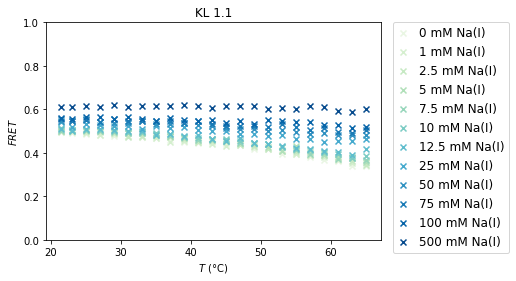

In [24]:
# erste Durchführung
fig = plt.figure()
ax = fig.add_subplot(111)
range=(-0.1,1)
temps = 27
palette = plt.get_cmap('GnBu',temps)

ax.scatter(blab.get_well(dataframe=df_II, wellnumber="A2")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="A2")["FRET"], marker="x", color=palette(2), label='0 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="B2")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="B2")["FRET"], marker="x", color=palette(5), label='1 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="C2")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="C2")["FRET"], marker="x", color=palette(7), label='2.5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="D2")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="D2")["FRET"], marker="x", color=palette(9), label='5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="E2")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="E2")["FRET"], marker="x", color=palette(11), label='7.5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="F2")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="F2")["FRET"], marker="x", color=palette(13), label='10 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="G2")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="G2")["FRET"], marker="x", color=palette(15), label='12.5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="H2")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="H2")["FRET"], marker="x", color=palette(17), label='25 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="A3")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="A3")["FRET"], marker="x", color=palette(19), label='50 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="B3")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="B3")["FRET"], marker="x", color=palette(21), label='75 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="C3")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="C3")["FRET"], marker="x", color=palette(23), label='100 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="D3")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="D3")["FRET"], marker="x", color=palette(25), label='500 mM Na(I)')
ax.legend(frameon=True, handlelength=0.95, fontsize='large', loc='upper right', bbox_to_anchor=(1.40, 1.03))
#ax.set_xlim([20,65])
ax.set_ylim([0.0,1.0])

plt.title("KL 1.1")
plt.xlabel('$T$ (°C)')
plt.ylabel("$FRET$")
plt.savefig("2023_05_22_RNA_NaCl_conc_range_KL1_1.png", dpi=600, bbox_inches="tight")

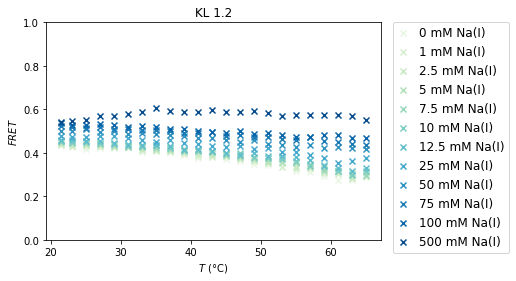

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
range=(-0.1,1)
temps = 27
palette = plt.get_cmap('GnBu',temps)

ax.scatter(blab.get_well(dataframe=df_II, wellnumber="A4")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="A4")["FRET"], marker="x", color=palette(2), label='0 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="B4")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="B4")["FRET"], marker="x", color=palette(5), label='1 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="C4")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="C4")["FRET"], marker="x", color=palette(7), label='2.5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="D4")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="D4")["FRET"], marker="x", color=palette(9), label='5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="E4")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="E4")["FRET"], marker="x", color=palette(11), label='7.5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="F4")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="F4")["FRET"], marker="x", color=palette(13), label='10 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="G4")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="G4")["FRET"], marker="x", color=palette(15), label='12.5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="H4")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="H4")["FRET"], marker="x", color=palette(17), label='25 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="A5")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="A5")["FRET"], marker="x", color=palette(19), label='50 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="B5")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="B5")["FRET"], marker="x", color=palette(21), label='75 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="C5")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="C5")["FRET"], marker="x", color=palette(23), label='100 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="D5")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="D5")["FRET"], marker="x", color=palette(25), label='500 mM Na(I)')
ax.legend(frameon=True, handlelength=0.95, fontsize='large', loc='upper right', bbox_to_anchor=(1.40, 1.03))
#ax.set_xlim([20,65])
ax.set_ylim([0.0,1.0])

plt.title("KL 1.2")
plt.xlabel('$T$ (°C)')
plt.ylabel("$FRET$")
plt.savefig("2023_05_22_RNA_NaCl_conc_range_KL1_2.png", dpi=600, bbox_inches="tight")

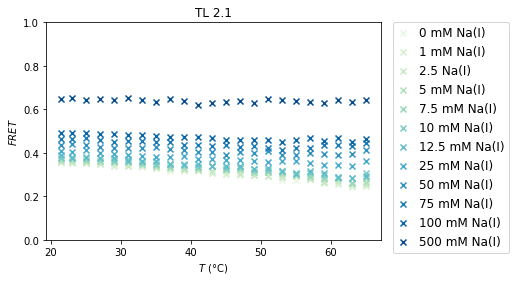

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
range=(-0.1,1)
temps = 27
palette = plt.get_cmap('GnBu',temps)

ax.scatter(blab.get_well(dataframe=df_II, wellnumber="A6")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="A6")["FRET"], marker="x", color=palette(2), label='0 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="B6")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="B6")["FRET"], marker="x", color=palette(5), label='1 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="C6")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="C6")["FRET"], marker="x", color=palette(7), label='2.5 Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="D6")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="D6")["FRET"], marker="x", color=palette(9), label='5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="E6")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="E6")["FRET"], marker="x", color=palette(11), label='7.5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="F6")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="F6")["FRET"], marker="x", color=palette(13), label='10 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="G6")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="G6")["FRET"], marker="x", color=palette(15), label='12.5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="H6")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="H6")["FRET"], marker="x", color=palette(17), label='25 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="A7")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="A7")["FRET"], marker="x", color=palette(19), label='50 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="B7")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="B7")["FRET"], marker="x", color=palette(21), label='75 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="C7")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="C7")["FRET"], marker="x", color=palette(23), label='100 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="D7")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="D7")["FRET"], marker="x",color=palette(25), label='500 mM Na(I)')
ax.legend(frameon=True, handlelength=0.95, fontsize='large', loc='upper right', bbox_to_anchor=(1.40, 1.03))
#ax.set_xlim([20,65])
ax.set_ylim([0.0,1.0])

plt.title("TL 2.1")
plt.xlabel('$T$ (°C)')
plt.ylabel("$FRET$")
plt.savefig("2023_05_22_RNA_NaCl_conc_range_TL2_1.png", dpi=600, bbox_inches="tight")

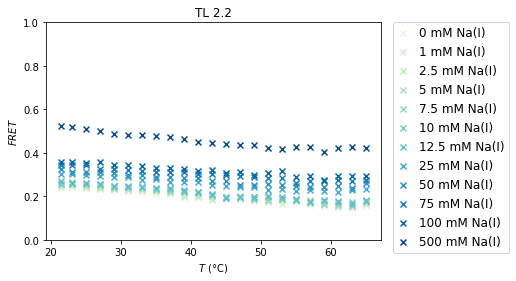

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
range=(-0.1,1)
temps = 27
palette = plt.get_cmap('GnBu',temps)

ax.scatter(blab.get_well(dataframe=df_II, wellnumber="A8")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="A8")["FRET"], marker="x", color=palette(2), label='0 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="B8")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="B8")["FRET"], marker="x", color=palette(5), label='1 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="C8")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="C8")["FRET"], marker="x", color=palette(7), label='2.5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="D8")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="D8")["FRET"], marker="x", color=palette(9), label='5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="E8")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="E8")["FRET"], marker="x", color=palette(11), label='7.5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="F8")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="F8")["FRET"], marker="x", color=palette(13), label='10 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="G8")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="G8")["FRET"], marker="x", color=palette(15), label='12.5 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="H8")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="H8")["FRET"], marker="x", color=palette(17), label='25 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="A9")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="A9")["FRET"], marker="x", color=palette(19), label='50 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="B9")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="B9")["FRET"], marker="x", color=palette(21), label='75 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="C9")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="C9")["FRET"], marker="x", color=palette(23), label='100 mM Na(I)')
ax.scatter(blab.get_well(dataframe=df_II, wellnumber="D9")["temperature (°C)"], \
           blab.get_well(dataframe=df_II, wellnumber="D9")["FRET"], marker="x", color=palette(25), label='500 mM Na(I)')
ax.legend(frameon=True, handlelength=0.95, fontsize='large', loc='upper right', bbox_to_anchor=(1.40, 1.03))
#ax.set_xlim([20,65])
ax.set_ylim([0.0,1.0])

plt.title("TL 2.2")
plt.xlabel('$T$ (°C)')
plt.ylabel("$FRET$")
plt.savefig("2023_05_22_RNA_NaCl_conc_range_TL2_2.png", dpi=600, bbox_inches="tight")

## FRET in Abhängigkeit der Konzentration und Hill-Fit

In [28]:
#df_II_noWell0 = df_II[(df_II['wellnumber']!="A2") & (df_II['wellnumber']!="A4") & (df_II['wellnumber']!="A6") & (df_II['wellnumber']!="A8")]
#print(df_II_noWell0["wellnumber"].unique())

### hier geht Felix Code kaputt, weil nun mehrere Konstrukte bei den gleichen Temperaturen vorhanden sind

deshalb für jedes Konstrukt einen df anlegenb --> in filtered_df geht kein bool ausdruck mit "construct"==

In [29]:
df_KL1_1 = df_II[df_II["construct"] == 1.1]
df_KL1_2 = df_II[df_II["construct"] == 1.2]
df_TL2_1 = df_II[df_II["construct"] == 2.1]
df_TL2_2 = df_II[df_II["construct"] == 2.2]
df_KL1_2

,temperature (°C),wellnumber,value (x)_x,I^Dem_Dex,I`^Dem_Dex,I``^Dem_Dex,concentration (mM),I`^Aem_Dex,I``^Aem_Dex,construct_x,value (x)_y,I^Aem_Dex,construct_y,value (x),I^Aem_Aex,construct,FRET
46,21.5,A4,1061004,1.057527e+06,1.057527e+06,1.057527e+06,0.0,925620.823169,815677.200863,1.2,1068057,1.064580e+06,1.2,5117134,5.113657e+06,1.2,0.435445
47,23.0,A4,1048295,1.044818e+06,1.044818e+06,1.044818e+06,0.0,894669.785769,784800.596463,1.2,1035436,1.031959e+06,1.2,5113672,5.110195e+06,1.2,0.428942
48,25.0,A4,1037598,1.034121e+06,1.034121e+06,1.034121e+06,0.0,845990.371569,740221.060263,1.2,985351,9.818739e+05,1.2,4922980,4.919503e+06,1.2,0.417181
49,27.0,A4,989483,9.860059e+05,9.860059e+05,9.860059e+05,0.0,827716.682569,723215.699263,1.2,960755,9.572779e+05,1.2,4863988,4.860511e+06,1.2,0.423126
50,29.0,A4,964860,9.613829e+05,9.613829e+05,9.613829e+05,0.0,798461.144769,698205.164463,1.2,928264,9.247869e+05,1.2,4666546,4.663069e+06,1.2,0.420710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,57.0,H4,518104,5.146269e+05,5.146269e+05,5.146269e+05,25.0,388267.883169,327475.754863,1.2,459367,4.558899e+05,1.2,2831018,2.827541e+06,1.2,0.388879
1054,59.0,H4,494069,4.905919e+05,4.905919e+05,4.905919e+05,25.0,353534.082169,297027.634863,1.2,421475,4.179979e+05,1.2,2631684,2.628207e+06,1.2,0.377121
1055,61.0,H4,476335,4.728579e+05,4.728579e+05,4.728579e+05,25.0,310006.329769,255817.689963,1.2,375617,3.721399e+05,1.2,2523879,2.520402e+06,1.2,0.351072
1056,63.0,H4,402489,3.990119e+05,3.990119e+05,3.990119e+05,25.0,273331.694169,225565.104363,1.2,329239,3.257619e+05,1.2,2225179,2.221702e+06,1.2,0.361149


      temperature (°C) wellnumber  value (x)_x     I^Dem_Dex    I`^Dem_Dex  \
140               25.0         A8      1533905  1.530428e+06  1.530428e+06   
163               25.0         A9      1304516  1.301039e+06  1.301039e+06   
324               25.0         B8      1477616  1.474139e+06  1.474139e+06   
347               25.0         B9      1351046  1.347569e+06  1.347569e+06   
508               25.0         C8      1487747  1.484270e+06  1.484270e+06   
531               25.0         C9      1289314  1.285837e+06  1.285837e+06   
692               25.0         D8      1686152  1.682675e+06  1.682675e+06   
715               25.0         D9       451038  4.475609e+05  4.475609e+05   
807               25.0         E8      1630667  1.627190e+06  1.627190e+06   
899               25.0         F8      1537507  1.534030e+06  1.534030e+06   
991               25.0         G8      1616773  1.613296e+06  1.613296e+06   
1083              25.0         H8      1484183  1.480706e+06  1.

C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/4169632573.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  left.set_xticklabels(['','0.00',''])
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/4169632573.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  right.set_xticklabels(values)


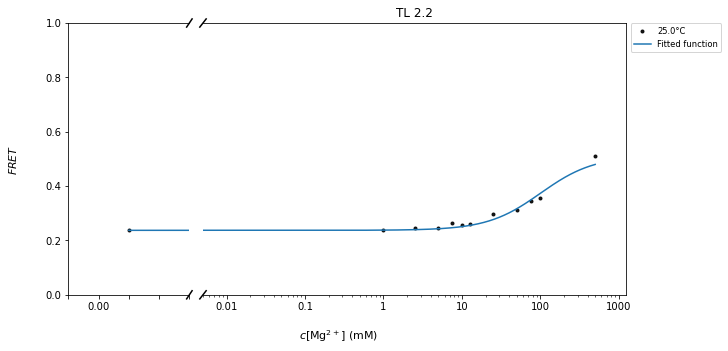

In [30]:
# filter the temperature 
filter_temperature = 25.0
filtered_df_TL2_2 = df_TL2_2[df_TL2_2["temperature (°C)"] ==filter_temperature]
print(filtered_df_TL2_2)

# define plot
f, (left, right) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=False, gridspec_kw={'width_ratios': [1, 3.5]})

plt.subplots_adjust(wspace = .05)

f.text(0.5, 0, '$c$[Mg$^{2+}$] (mM)', ha='center', fontsize=11)
f.text(0.04, 0.5, '$\mathit{FRET}$', va='center', rotation='vertical', fontsize=11)

# create values for x-scale
values= ['0','0','0.01','0.1','1','10','100', '1000']

# calculate Hill parameters
def hill_function(x,k_eq,n):
    return min(filtered_df_TL2_2["FRET"]) + (max(filtered_df_TL2_2["FRET"]) - min(filtered_df_TL2_2["FRET"])) * (x**n / (k_eq + x**n))

params, params_covariance = optimize.curve_fit(hill_function, filtered_df_TL2_2["concentration (mM)"], filtered_df_TL2_2["FRET"])
print('K_eq ='), print(params[0]), print('n ='), print(params[1])

# draw plot for the two plots
left.scatter(filtered_df_TL2_2["concentration (mM)"], filtered_df_TL2_2["FRET"], marker='.', color='black', linewidth=1, alpha=0.9, label=f'{filter_temperature}°C')
right.scatter(filtered_df_TL2_2["concentration (mM)"], filtered_df_TL2_2["FRET"], marker='.', color='black', linewidth=1, alpha=0.9, label=f'{filter_temperature}°C')
right.plot(np.arange(0,500,0.1).reshape((-1,1)), hill_function(np.arange(0,500,0.1).reshape((-1,1)), params[0], params[1]),
         label='Fitted function')
left.plot(filtered_df_TL2_2["concentration (mM)"], hill_function(filtered_df_TL2_2["concentration (mM)"], params[0], params[1]),
         label='Fitted function')

# specifications for the left plot
left.set_ylim([0,1])
left.set_xticklabels(['','0.00',''])
left.set_xlim(-0.05,0.05)
left.spines['right'].set_visible(False)

# specifications for the right plot
right.set_xscale('log')
right.set_xticklabels(values)
right.set_xlim(0.005, 1250)
right.spines['left'].set_visible(False)
right.get_yaxis().set_visible(False)   

# define strokes
d = .015 
kwargs = dict(transform=left.transAxes, color='k', clip_on=False)
left.plot((1-d*1.5,1+d*1.5), (-d,+d), ** kwargs)
left.plot((1-d*1.5,1+d*1.5),(1-d,1+d), ** kwargs)
kwargs.update(transform=right.transAxes)
right.plot((-d/2,+d/2), (1-d,1+d), ** kwargs)
right.plot((-d/2,+d/2), (-d,+d), ** kwargs)

plt.title("TL 2.2")
# legend
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='small', borderaxespad=0)
plt.savefig("2023_05_22_RNA_NaCl_25C_TL2_2.png", dpi=600, bbox_inches="tight")
plt.show()

C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/978661757.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  left.set_xticklabels(['','','0.00',''])
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/978661757.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  right.set_xticklabels(values)
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/978661757.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  left.set_xticklabels(['','','0.00',''])
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/978661757.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  right.set_xticklabels(values)


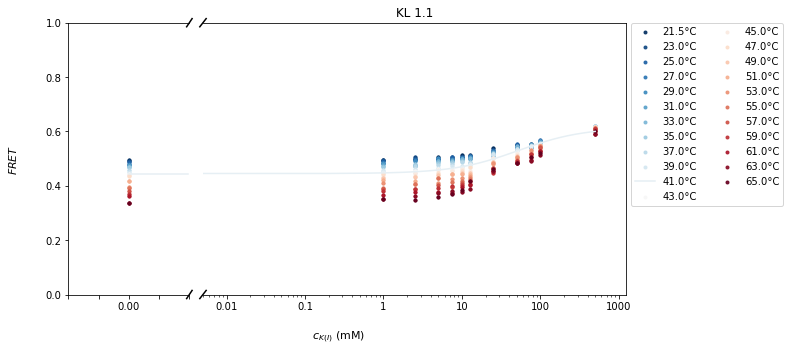

In [31]:
f, (left, right) = plt.subplots(1, 2,figsize=(10,5), sharey=True, sharex=False, gridspec_kw={'width_ratios': [1, 3.5]})

plt.subplots_adjust(wspace = .05)

f.text(0.5, 0, '$c_{K(I)}$ (mM)', ha='center', fontsize=11)
f.text(0.04, 0.5, '$\mathit{FRET}$', va='center', rotation='vertical', fontsize=11)

# create values for x-scale
values= ['0','0','0.01','0.1','1','10','100', '1000']
paralist_KL1_1 = []
# draw plot for the two plots
temps = df_II["temperature (°C)"].unique()
palette = plt.get_cmap('RdBu_r',len(temps))
#print(temps[:])
num=-1
for i in temps[:]:
    num+=1
    filtered_df = df_KL1_1[df_KL1_1["temperature (°C)"] == i]
    def hill_function(x,k_eq,n):
        return min(filtered_df["FRET"]) + (max(filtered_df["FRET"]) - min(filtered_df["FRET"])) * (x**n / (k_eq + x**n))
    params, params_covariance = optimize.curve_fit(hill_function, filtered_df["concentration (mM)"], filtered_df["FRET"])
    paralist_KL1_1.append([params[0], params[1]]) 
    left.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)#, label=str(i)+'°C'
    right.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)#, label=str(i)+'°C'
    #right.plot(np.arange(0,500,0.1).reshape((-1,1)), hill_function(np.arange(0,500,0.1).reshape((-1,1)), params[0], params[1]), color=palette(num))
    #left.plot(np.arange(0,0.005,0.0001).reshape((-1,1)), hill_function(np.arange(0,0.005,0.0001).reshape((-1,1)), params[0], params[1]),color=palette(num))
    
    if i == 41:
        left.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)
        right.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)
        right.plot(np.arange(0,500,0.1).reshape((-1,1)), hill_function(np.arange(0,500,0.1).reshape((-1,1)), params[0], params[1]), color=palette(num),label=str(i)+'°C')
        left.plot(np.arange(0,0.005,0.0001).reshape((-1,1)), hill_function(np.arange(0,0.005,0.0001).reshape((-1,1)), params[0], params[1]),color=palette(num), label=str(i)+'°C')
    else:
        left.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9, label=str(i)+'°C')
        right.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9, label=str(i)+'°C')
    
# specifications for the left plot
    left.set_ylim([0,1])
    left.set_xticklabels(['','','0.00',''])
    left.set_xlim(-0.005,0.005)
    left.set_ylim(0.0, 1.0)
    left.spines['right'].set_visible(False)

# specifications for the right plot
    right.set_xscale('log')
    right.set_xticklabels(values)
    right.set_xlim(0.005, 1250)
    right.set_ylim(0.0, 1.0)
    right.spines['left'].set_visible(False)
    right.get_yaxis().set_visible(False)   

# define strokes
d = .015 
kwargs = dict(transform=left.transAxes, color='k', clip_on=False)
left.plot((1-d*1.5,1+d*1.5), (-d,+d), ** kwargs)
left.plot((1-d*1.5,1+d*1.5),(1-d,1+d), ** kwargs)
kwargs.update(transform=right.transAxes)
right.plot((-d/2,+d/2), (1-d,1+d), ** kwargs)
right.plot((-d/2,+d/2), (-d,+d), ** kwargs)

plt.title("KL 1.1")
# legend
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='10', borderaxespad=0, ncol=2)
plt.savefig("2023_05_22_RNA_NaCl_titration_fit_KL1_1.png", dpi=600, bbox_inches="tight")

In [32]:
list_x_KL1_1 = pd.DataFrame(paralist_KL1_1)
df_temp = pd.DataFrame(df_KL1_1["temperature (°C)"].unique())

list_y_KL1_1 = pd.concat([df_temp, list_x_KL1_1], axis=1, ignore_index=True)
list_y_KL1_1.insert(0, 'construct', "1.2")
hill_KL1_1 = list_y_KL1_1.rename(columns={0 : "temperature (°C)", 1 : "K_eq", 2 : "n"})
#list_y_KL1_1.to_csv('2023_05_10_RNA_MgCl2_titr_hill_params_KL11.csv', index=False)
#list_y_KL1_1 = pd.read_csv('2023_05_10_RNA_MgCl2_titr_hill_params_KL11.csv')
#hill_KL1_1

C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/2799086014.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  left.set_xticklabels(['','','0.00',''])
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/2799086014.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  right.set_xticklabels(values)
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/2799086014.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  left.set_xticklabels(['','','0.00',''])
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/2799086014.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  right.set_xticklabels(values)


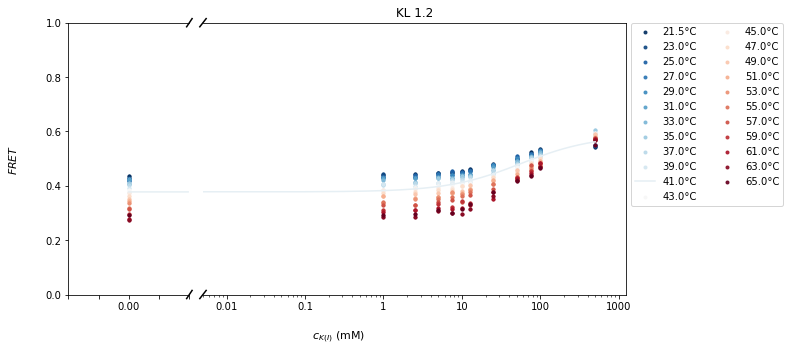

In [33]:
f, (left, right) = plt.subplots(1, 2,figsize=(10,5), sharey=True, sharex=False, gridspec_kw={'width_ratios': [1, 3.5]})

plt.subplots_adjust(wspace = .05)

f.text(0.5, 0, '$c_{K(I)}$ (mM)', ha='center', fontsize=11)
f.text(0.04, 0.5, '$\mathit{FRET}$', va='center', rotation='vertical', fontsize=11)

# create values for x-scale
values= ['0','0','0.01','0.1','1','10','100', '1000']
paralist_KL1_2 = []
# draw plot for the two plots
temps = df_II["temperature (°C)"].unique()
palette = plt.get_cmap('RdBu_r',len(temps))
#print(temps[:])
num=-1
for i in temps[:]:
    num+=1
    filtered_df = df_KL1_2[df_KL1_2["temperature (°C)"] == i]
    def hill_function(x,k_eq,n):
        return min(filtered_df["FRET"]) + (max(filtered_df["FRET"]) - min(filtered_df["FRET"])) * (x**n / (k_eq + x**n))
    params, params_covariance = optimize.curve_fit(hill_function, filtered_df["concentration (mM)"], filtered_df["FRET"])
    paralist_KL1_2.append([params[0], params[1]]) 
    left.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)#, label=str(i)+'°C'
    right.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)#, label=str(i)+'°C'
    #right.plot(np.arange(0,500,0.1).reshape((-1,1)), hill_function(np.arange(0,500,0.1).reshape((-1,1)), params[0], params[1]), color=palette(num))
    #left.plot(np.arange(0,0.005,0.0001).reshape((-1,1)), hill_function(np.arange(0,0.005,0.0001).reshape((-1,1)), params[0], params[1]),color=palette(num))
    
    if i == 41:
        left.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)
        right.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)
        right.plot(np.arange(0,500,0.1).reshape((-1,1)), hill_function(np.arange(0,500,0.1).reshape((-1,1)), params[0], params[1]), color=palette(num),label=str(i)+'°C')
        left.plot(np.arange(0,0.005,0.0001).reshape((-1,1)), hill_function(np.arange(0,0.005,0.0001).reshape((-1,1)), params[0], params[1]),color=palette(num), label=str(i)+'°C')
    else:
        left.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9, label=str(i)+'°C')
        right.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9, label=str(i)+'°C')
    
# specifications for the left plot
    left.set_ylim([0,1])
    left.set_xticklabels(['','','0.00',''])
    left.set_xlim(-0.005,0.005)
    left.set_ylim(0.0, 1.0)
    left.spines['right'].set_visible(False)

# specifications for the right plot
    right.set_xscale('log')
    right.set_xticklabels(values)
    right.set_xlim(0.005, 1250)
    right.set_ylim(0.0, 1.0)
    right.spines['left'].set_visible(False)
    right.get_yaxis().set_visible(False)   

# define strokes
d = .015 
kwargs = dict(transform=left.transAxes, color='k', clip_on=False)
left.plot((1-d*1.5,1+d*1.5), (-d,+d), ** kwargs)
left.plot((1-d*1.5,1+d*1.5),(1-d,1+d), ** kwargs)
kwargs.update(transform=right.transAxes)
right.plot((-d/2,+d/2), (1-d,1+d), ** kwargs)
right.plot((-d/2,+d/2), (-d,+d), ** kwargs)

plt.title("KL 1.2")
# legend
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='10', borderaxespad=0, ncol=2)
plt.savefig("2023_05_22_RNA_NaCl_titration_fit_KL1_2.png", dpi=600, bbox_inches="tight")

In [34]:
list_x_KL1_2 = pd.DataFrame(paralist_KL1_2)
df_temp = pd.DataFrame(df_KL1_2["temperature (°C)"].unique())

list_y_KL1_2 = pd.concat([df_temp, list_x_KL1_2], axis=1, ignore_index=True)
list_y_KL1_2.insert(0, 'construct', "1.2")
hill_KL1_2 = list_y_KL1_2.rename(columns={0 : "temperature (°C)", 1 : "K_eq", 2 : "n"})
#list_y_KL1_2.to_csv('2023_05_10_RNA_MgCl2_titr_hill_params_KL12.csv', index=False)
#list_y_KL1_2 = pd.read_csv('2023_05_10_RNA_MgCl2_titr_hill_params_KL12.csv')
#hill_KL1_2

C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/898076089.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  left.set_xticklabels(['','','0.00',''])
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/898076089.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  right.set_xticklabels(values)
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/898076089.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  left.set_xticklabels(['','','0.00',''])
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/898076089.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  right.set_xticklabels(values)


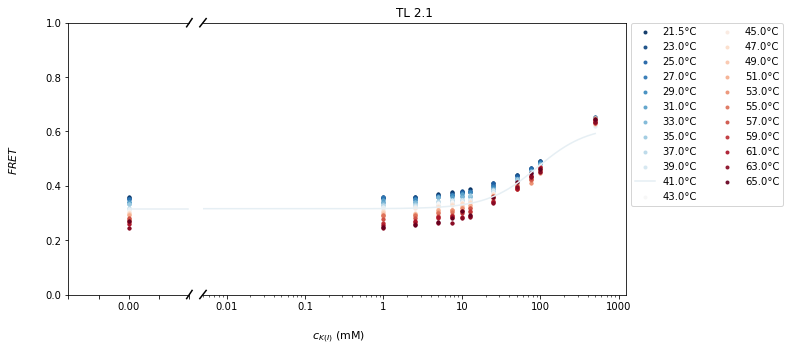

In [35]:
f, (left, right) = plt.subplots(1, 2,figsize=(10,5), sharey=True, sharex=False, gridspec_kw={'width_ratios': [1, 3.5]})

plt.subplots_adjust(wspace = .05)

f.text(0.5, 0, '$c_{K(I)}$ (mM)', ha='center', fontsize=11)
f.text(0.04, 0.5, '$\mathit{FRET}$', va='center', rotation='vertical', fontsize=11)

# create values for x-scale
values= ['0','0','0.01','0.1','1','10','100', '1000']
paralist_TL2_1 = []
# draw plot for the two plots
temps = df_II["temperature (°C)"].unique()
palette = plt.get_cmap('RdBu_r',len(temps))
#print(temps[:])
num=-1
for i in temps[:]:
    num+=1
    filtered_df = df_TL2_1[df_TL2_1["temperature (°C)"] == i]
    def hill_function(x,k_eq,n):
        return min(filtered_df["FRET"]) + (max(filtered_df["FRET"]) - min(filtered_df["FRET"])) * (x**n / (k_eq + x**n))
    params, params_covariance = optimize.curve_fit(hill_function, filtered_df["concentration (mM)"], filtered_df["FRET"])
    paralist_TL2_1.append([params[0], params[1]])  
    left.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)#, label=str(i)+'°C'
    right.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)#, label=str(i)+'°C'
    #right.plot(np.arange(0,500,0.1).reshape((-1,1)), hill_function(np.arange(0,500,0.1).reshape((-1,1)), params[0], params[1]), color=palette(num))
    #left.plot(np.arange(0,0.005,0.0001).reshape((-1,1)), hill_function(np.arange(0,0.005,0.0001).reshape((-1,1)), params[0], params[1]),color=palette(num))
    
    if i == 41:
        left.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)
        right.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)
        right.plot(np.arange(0,500,0.1).reshape((-1,1)), hill_function(np.arange(0,500,0.1).reshape((-1,1)), params[0], params[1]), color=palette(num),label=str(i)+'°C')
        left.plot(np.arange(0,0.005,0.0001).reshape((-1,1)), hill_function(np.arange(0,0.005,0.0001).reshape((-1,1)), params[0], params[1]),color=palette(num), label=str(i)+'°C')
    else:
        left.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9, label=str(i)+'°C')
        right.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9, label=str(i)+'°C')
    
# specifications for the left plot
    left.set_ylim([0,1])
    left.set_xticklabels(['','','0.00',''])
    left.set_xlim(-0.005,0.005)
    left.set_ylim(0.0, 1.0)
    left.spines['right'].set_visible(False)

# specifications for the right plot
    right.set_xscale('log')
    right.set_xticklabels(values)
    right.set_xlim(0.005, 1250)
    right.set_ylim(0.0, 1.0)
    right.spines['left'].set_visible(False)
    right.get_yaxis().set_visible(False)   

# define strokes
d = .015 
kwargs = dict(transform=left.transAxes, color='k', clip_on=False)
left.plot((1-d*1.5,1+d*1.5), (-d,+d), ** kwargs)
left.plot((1-d*1.5,1+d*1.5),(1-d,1+d), ** kwargs)
kwargs.update(transform=right.transAxes)
right.plot((-d/2,+d/2), (1-d,1+d), ** kwargs)
right.plot((-d/2,+d/2), (-d,+d), ** kwargs)

plt.title("TL 2.1")
# legend
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='10', borderaxespad=0, ncol=2)
plt.savefig("2023_05_22_RNA_NaCl_titration_fit_TL2_1.png", dpi=600, bbox_inches="tight")

In [36]:
list_x_TL2_1 = pd.DataFrame(paralist_TL2_1)
df_temp = pd.DataFrame(df_TL2_1["temperature (°C)"].unique())

list_y_TL2_1 = pd.concat([df_temp, list_x_TL2_1], axis=1, ignore_index=True)
list_y_TL2_1.insert(0, 'construct', "2.1")
hill_TL2_1 = list_y_TL2_1.rename(columns={0 : "temperature (°C)", 1 : "K_eq", 2 : "n"})
#hill_TL2_1.to_csv('2023_05_10_RNA_MgCl2_titr_hill_params_TL21.csv', index=False)
#list_y_TL2_1 = pd.read_csv('2023_05_10_RNA_MgCl2_titr_hill_params_TL21.csv')
#hill_TL2_1

C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/273188244.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  left.set_xticklabels(['','','0.00',''])
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/273188244.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  right.set_xticklabels(values)
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/273188244.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  left.set_xticklabels(['','','0.00',''])
C:\Users\schuman2\AppData\Local\Temp/ipykernel_10648/273188244.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  right.set_xticklabels(values)


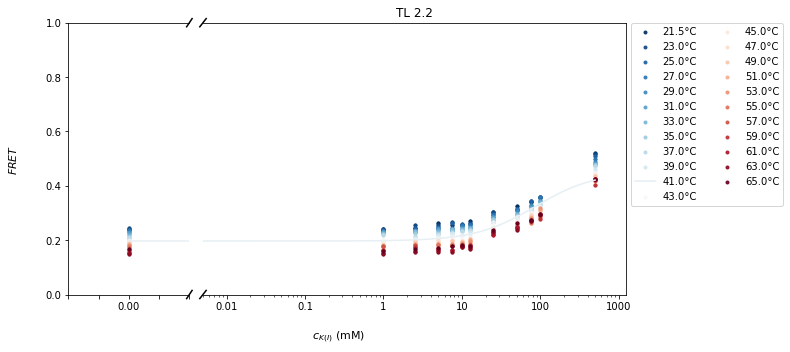

In [37]:
f, (left, right) = plt.subplots(1, 2,figsize=(10,5), sharey=True, sharex=False, gridspec_kw={'width_ratios': [1, 3.5]})

plt.subplots_adjust(wspace = .05)

f.text(0.5, 0, '$c_{K(I)}$ (mM)', ha='center', fontsize=11)
f.text(0.04, 0.5, '$\mathit{FRET}$', va='center', rotation='vertical', fontsize=11)

# create values for x-scale
values= ['0','0','0.01','0.1','1','10','100', '1000']
paralist_TL2_2 = []
# draw plot for the two plots
temps = df_II["temperature (°C)"].unique()
palette = plt.get_cmap('RdBu_r',len(temps))
#print(temps[:])
num=-1
for i in temps[:]:
    num+=1
    filtered_df = df_TL2_2[df_TL2_2["temperature (°C)"] == i]
    def hill_function(x,k_eq,n):
        return min(filtered_df["FRET"]) + (max(filtered_df["FRET"]) - min(filtered_df["FRET"])) * (x**n / (k_eq + x**n))
    params, params_covariance = optimize.curve_fit(hill_function, filtered_df["concentration (mM)"], filtered_df["FRET"])
    paralist_TL2_2.append([params[0], params[1]])
    left.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)#, label=str(i)+'°C'
    right.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)#, label=str(i)+'°C'
    #right.plot(np.arange(0,500,0.1).reshape((-1,1)), hill_function(np.arange(0,500,0.1).reshape((-1,1)), params[0], params[1]), color=palette(num))
    #left.plot(np.arange(0,0.005,0.0001).reshape((-1,1)), hill_function(np.arange(0,0.005,0.0001).reshape((-1,1)), params[0], params[1]),color=palette(num))
    
    if i == 41:
        left.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)
        right.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9)
        right.plot(np.arange(0,500,0.1).reshape((-1,1)), hill_function(np.arange(0,500,0.1).reshape((-1,1)), params[0], params[1]), color=palette(num),label=str(i)+'°C')
        left.plot(np.arange(0,0.005,0.0001).reshape((-1,1)), hill_function(np.arange(0,0.005,0.0001).reshape((-1,1)), params[0], params[1]),color=palette(num), label=str(i)+'°C')
    else:
        left.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9, label=str(i)+'°C')
        right.scatter(filtered_df["concentration (mM)"], filtered_df["FRET"], marker='.', color=palette(num), linewidth=1, alpha=0.9, label=str(i)+'°C')
    
# specifications for the left plot
    left.set_ylim([0,1])
    left.set_xticklabels(['','','0.00',''])
    left.set_xlim(-0.001,0.001)
    left.set_ylim(0.0, 1.0)
    left.spines['right'].set_visible(False)

# specifications for the right plot
    right.set_xscale('log')
    right.set_xticklabels(values)
    right.set_xlim(0.005, 1250)
    right.set_ylim(0.0, 1.0)
    right.spines['left'].set_visible(False)
    right.get_yaxis().set_visible(False)   

# define strokes
d = .015 
kwargs = dict(transform=left.transAxes, color='k', clip_on=False)
left.plot((1-d*1.5,1+d*1.5), (-d,+d), ** kwargs)
left.plot((1-d*1.5,1+d*1.5),(1-d,1+d), ** kwargs)
kwargs.update(transform=right.transAxes)
right.plot((-d/2,+d/2), (1-d,1+d), ** kwargs)
right.plot((-d/2,+d/2), (-d,+d), ** kwargs)

plt.title("TL 2.2")
# legend
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='10', borderaxespad=0, ncol=2)
plt.savefig("2023_05_22_RNA_NaCl_titration_fit_TL2_2.png", dpi=600, bbox_inches="tight")

In [38]:
list_x_TL2_2 = pd.DataFrame(paralist_TL2_2)
df_temp = pd.DataFrame(df_TL2_2["temperature (°C)"].unique())

list_y_TL2_2 = pd.concat([df_temp, list_x_TL2_2], axis=1, ignore_index=True)
list_y_TL2_2.insert(0, 'construct', "2.2")
hill_TL2_2 = list_y_TL2_2.rename(columns={0 : "temperature (°C)", 1 : "K_eq", 2 : "n"})
#list_y_TL2_2.to_csv('2023_05_10_RNA_MgCl2_titr_hill_params_TL22.csv', index=False)
#list_y_TL2_2 = pd.read_csv('2023_05_10_RNA_MgCl2_titr_hill_params_TL22.csv')
#hill_TL2_2

### Hill-Fit-Parameter

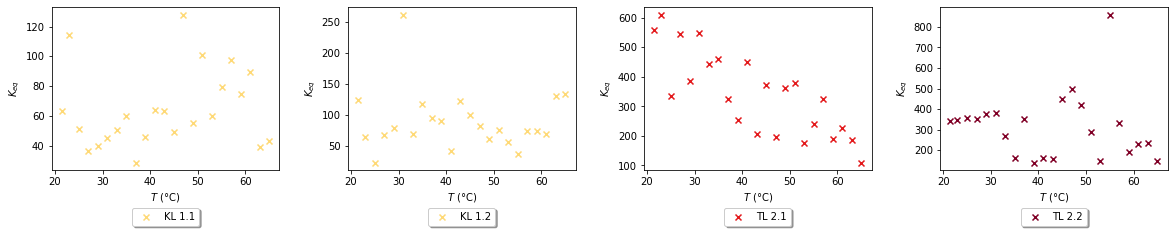

In [39]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 3), sharex=False, sharey=False, squeeze=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
temps = 21
palette = plt.get_cmap('YlOrRd',temps)
#left  = # the left side of the subplots of the figure
#right = # the right side of the subplots of the figure
#bottom =  # the bottom of the subplots of the figure
#top =  # the top of the subplots of the figure
#wspace = # the amount of width reserved for blank space between subplots
#hspace = # the amount of height reserved for white space between subplots

#range = [-0.1,1] # y achse
ax[0,0].scatter(hill_KL1_1["temperature (°C)"] , hill_KL1_1["K_eq"], marker="x", color=palette(5), label='KL 1.1')
leg = ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, fancybox=True, ncol=1)
#ax[0,0].set_title("KL 1.2")
#ax[0,0].set_xlim([15,70])
#ax[0,0].set_ylim([20,70])

ax[0,1].scatter(hill_KL1_2["temperature (°C)"] , hill_KL1_2["K_eq"], marker="x", color=palette(5), label='KL 1.2')
leg = ax[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, fancybox=True, ncol=1)
#ax[0,1].set_title("KL 1.2")
#ax[0,1].set_xlim([15,70])
#ax[0,1].set_ylim([20,70])


ax[0,2].scatter(hill_TL2_1["temperature (°C)"] , hill_TL2_1["K_eq"], marker="x", color=palette(15), label='TL 2.1')
leg = ax[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, fancybox=True, ncol=1)
#ax[0,2].set_title("TL 2.1")
#ax[0,2].set_xlim([15,70])
#ax[0,2].set_ylim([20,70])


ax[0,3].scatter(hill_TL2_2["temperature (°C)"] , hill_TL2_2["K_eq"], marker="x", color=palette(20), label='TL 2.2')
leg = ax[0,3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, fancybox=True, ncol=1)
#ax[0,3].set_title("TL 2.2")
#ax[0,3].set_xlim([15,70])
#ax[0,3].set_ylim([50,235])


# set labels
plt.setp(ax[:, :], xlabel='$T$ (°C)')
plt.setp(ax[:, :], ylabel='$K_{eq}$')

plt.savefig("2023_05_22_RNA_NaCl_hill_param2.png", dpi=600, bbox_inches="tight")
plt.show()

In [40]:
#hill_KL1_1
#hill_KL1_2
#hill_TL2_1
#hill_TL2_2

In [41]:
df_KL1_1_21 = df_KL1_1[df_KL1_1["temperature (°C)"] == 21.5] 
df_KL1_1_23 = df_KL1_1[df_KL1_1["temperature (°C)"] == 23.0]
df_KL1_1_25 = df_KL1_1[df_KL1_1["temperature (°C)"] == 25.0]
df_KL1_1_27 = df_KL1_1[df_KL1_1["temperature (°C)"] == 27.0]
df_KL1_1_29 = df_KL1_1[df_KL1_1["temperature (°C)"] == 29.0]
df_KL1_1_31 = df_KL1_1[df_KL1_1["temperature (°C)"] == 31.0]
df_KL1_1_33 = df_KL1_1[df_KL1_1["temperature (°C)"] == 33.0]
df_KL1_1_35 = df_KL1_1[df_KL1_1["temperature (°C)"] == 35.0]
df_KL1_1_37 = df_KL1_1[df_KL1_1["temperature (°C)"] == 37.0]
df_KL1_1_39 = df_KL1_1[df_KL1_1["temperature (°C)"] == 39.0]
df_KL1_1_41 = df_KL1_1[df_KL1_1["temperature (°C)"] == 41.0]
df_KL1_1_43 = df_KL1_1[df_KL1_1["temperature (°C)"] == 43.0]
df_KL1_1_45 = df_KL1_1[df_KL1_1["temperature (°C)"] == 45.0]
df_KL1_1_47 = df_KL1_1[df_KL1_1["temperature (°C)"] == 47.0]
df_KL1_1_49 = df_KL1_1[df_KL1_1["temperature (°C)"] == 49.0]
df_KL1_1_51 = df_KL1_1[df_KL1_1["temperature (°C)"] == 51.0]
df_KL1_1_53 = df_KL1_1[df_KL1_1["temperature (°C)"] == 53.0]
df_KL1_1_55 = df_KL1_1[df_KL1_1["temperature (°C)"] == 55.0]
df_KL1_1_57 = df_KL1_1[df_KL1_1["temperature (°C)"] == 57.0]
df_KL1_1_59 = df_KL1_1[df_KL1_1["temperature (°C)"] == 59.0]
df_KL1_1_61 = df_KL1_1[df_KL1_1["temperature (°C)"] == 61.0]
df_KL1_1_63 = df_KL1_1[df_KL1_1["temperature (°C)"] == 63.0]
df_KL1_1_65 = df_KL1_1[df_KL1_1["temperature (°C)"] == 65.0]

df_KL1_2_21 = df_KL1_2[df_KL1_2["temperature (°C)"] == 21.5] 
df_KL1_2_23 = df_KL1_2[df_KL1_2["temperature (°C)"] == 23.0]
df_KL1_2_25 = df_KL1_2[df_KL1_2["temperature (°C)"] == 25.0]
df_KL1_2_27 = df_KL1_2[df_KL1_2["temperature (°C)"] == 27.0]
df_KL1_2_29 = df_KL1_2[df_KL1_2["temperature (°C)"] == 29.0]
df_KL1_2_31 = df_KL1_2[df_KL1_2["temperature (°C)"] == 31.0]
df_KL1_2_33 = df_KL1_2[df_KL1_2["temperature (°C)"] == 33.0]
df_KL1_2_35 = df_KL1_2[df_KL1_2["temperature (°C)"] == 35.0]
df_KL1_2_37 = df_KL1_2[df_KL1_2["temperature (°C)"] == 37.0]
df_KL1_2_39 = df_KL1_2[df_KL1_2["temperature (°C)"] == 39.0]
df_KL1_2_41 = df_KL1_2[df_KL1_2["temperature (°C)"] == 41.0]
df_KL1_2_43 = df_KL1_2[df_KL1_2["temperature (°C)"] == 43.0]
df_KL1_2_45 = df_KL1_2[df_KL1_2["temperature (°C)"] == 45.0]
df_KL1_2_47 = df_KL1_2[df_KL1_2["temperature (°C)"] == 47.0]
df_KL1_2_49 = df_KL1_2[df_KL1_2["temperature (°C)"] == 49.0]
df_KL1_2_51 = df_KL1_2[df_KL1_2["temperature (°C)"] == 51.0]
df_KL1_2_53 = df_KL1_2[df_KL1_2["temperature (°C)"] == 53.0]
df_KL1_2_55 = df_KL1_2[df_KL1_2["temperature (°C)"] == 55.0]
df_KL1_2_57 = df_KL1_2[df_KL1_2["temperature (°C)"] == 57.0]
df_KL1_2_59 = df_KL1_2[df_KL1_2["temperature (°C)"] == 59.0]
df_KL1_2_61 = df_KL1_2[df_KL1_2["temperature (°C)"] == 61.0]
df_KL1_2_63 = df_KL1_2[df_KL1_2["temperature (°C)"] == 63.0]
df_KL1_2_65 = df_KL1_2[df_KL1_2["temperature (°C)"] == 65.0]

df_TL2_1_21 = df_TL2_1[df_TL2_1["temperature (°C)"] == 21.5] 
df_TL2_1_23 = df_TL2_1[df_TL2_1["temperature (°C)"] == 23.0]
df_TL2_1_25 = df_TL2_1[df_TL2_1["temperature (°C)"] == 25.0]
df_TL2_1_27 = df_TL2_1[df_TL2_1["temperature (°C)"] == 27.0]
df_TL2_1_29 = df_TL2_1[df_TL2_1["temperature (°C)"] == 29.0]
df_TL2_1_31 = df_TL2_1[df_TL2_1["temperature (°C)"] == 31.0]
df_TL2_1_33 = df_TL2_1[df_TL2_1["temperature (°C)"] == 33.0]
df_TL2_1_35 = df_TL2_1[df_TL2_1["temperature (°C)"] == 35.0]
df_TL2_1_37 = df_TL2_1[df_TL2_1["temperature (°C)"] == 37.0]
df_TL2_1_39 = df_TL2_1[df_TL2_1["temperature (°C)"] == 39.0]
df_TL2_1_41 = df_TL2_1[df_TL2_1["temperature (°C)"] == 41.0]
df_TL2_1_43 = df_TL2_1[df_TL2_1["temperature (°C)"] == 43.0]
df_TL2_1_45 = df_TL2_1[df_TL2_1["temperature (°C)"] == 45.0]
df_TL2_1_47 = df_TL2_1[df_TL2_1["temperature (°C)"] == 47.0]
df_TL2_1_49 = df_TL2_1[df_TL2_1["temperature (°C)"] == 49.0]
df_TL2_1_51 = df_TL2_1[df_TL2_1["temperature (°C)"] == 51.0]
df_TL2_1_53 = df_TL2_1[df_TL2_1["temperature (°C)"] == 53.0]
df_TL2_1_55 = df_TL2_1[df_TL2_1["temperature (°C)"] == 55.0]
df_TL2_1_57 = df_TL2_1[df_TL2_1["temperature (°C)"] == 57.0]
df_TL2_1_59 = df_TL2_1[df_TL2_1["temperature (°C)"] == 59.0]
df_TL2_1_61 = df_TL2_1[df_TL2_1["temperature (°C)"] == 61.0]
df_TL2_1_63 = df_TL2_1[df_TL2_1["temperature (°C)"] == 63.0]
df_TL2_1_65 = df_TL2_1[df_TL2_1["temperature (°C)"] == 65.0]


df_TL2_2_21 = df_TL2_2[df_TL2_2["temperature (°C)"] == 21.5] 
df_TL2_2_23 = df_TL2_2[df_TL2_2["temperature (°C)"] == 23.0]
df_TL2_2_25 = df_TL2_2[df_TL2_2["temperature (°C)"] == 25.0]
df_TL2_2_27 = df_TL2_2[df_TL2_2["temperature (°C)"] == 27.0]
df_TL2_2_29 = df_TL2_2[df_TL2_2["temperature (°C)"] == 29.0]
df_TL2_2_31 = df_TL2_2[df_TL2_2["temperature (°C)"] == 31.0]
df_TL2_2_33 = df_TL2_2[df_TL2_2["temperature (°C)"] == 33.0]
df_TL2_2_35 = df_TL2_2[df_TL2_2["temperature (°C)"] == 35.0]
df_TL2_2_37 = df_TL2_2[df_TL2_2["temperature (°C)"] == 37.0]
df_TL2_2_39 = df_TL2_2[df_TL2_2["temperature (°C)"] == 39.0]
df_TL2_2_41 = df_TL2_2[df_TL2_2["temperature (°C)"] == 41.0]
df_TL2_2_43 = df_TL2_2[df_TL2_2["temperature (°C)"] == 43.0]
df_TL2_2_45 = df_TL2_2[df_TL2_2["temperature (°C)"] == 45.0]
df_TL2_2_47 = df_TL2_2[df_TL2_2["temperature (°C)"] == 47.0]
df_TL2_2_49 = df_TL2_2[df_TL2_2["temperature (°C)"] == 49.0]
df_TL2_2_51 = df_TL2_2[df_TL2_2["temperature (°C)"] == 51.0]
df_TL2_2_53 = df_TL2_2[df_TL2_2["temperature (°C)"] == 53.0]
df_TL2_2_55 = df_TL2_2[df_TL2_2["temperature (°C)"] == 55.0]
df_TL2_2_57 = df_TL2_2[df_TL2_2["temperature (°C)"] == 57.0]
df_TL2_2_59 = df_TL2_2[df_TL2_2["temperature (°C)"] == 59.0]
df_TL2_2_61 = df_TL2_2[df_TL2_2["temperature (°C)"] == 61.0]
df_TL2_2_63 = df_TL2_2[df_TL2_2["temperature (°C)"] == 63.0]
df_TL2_2_65 = df_TL2_2[df_TL2_2["temperature (°C)"] == 65.0]
#print(df_TL2_1_21)

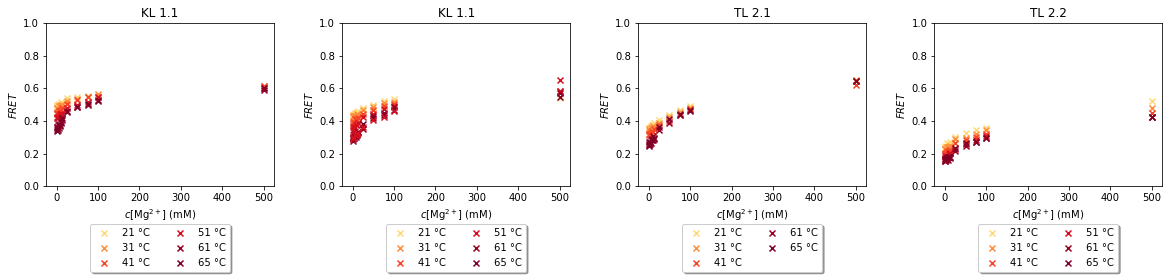

In [42]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 3), sharex=False, sharey=False, squeeze=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
temps = 21
palette = plt.get_cmap('YlOrRd',temps)
#left  = # the left side of the subplots of the figure
#right = # the right side of the subplots of the figure
#bottom =  # the bottom of the subplots of the figure
#top =  # the top of the subplots of the figure
#wspace = # the amount of width reserved for blank space between subplots
#hspace = # the amount of height reserved for white space between subplots

#range = [-0.1,1] # y achse
ax[0,0].scatter(df_KL1_1_21["concentration (mM)"] , df_KL1_1_21["FRET"], marker="x", color=palette(5), label='21 °C')
ax[0,0].scatter(df_KL1_1_31["concentration (mM)"] , df_KL1_1_31["FRET"], marker="x", color=palette(10), label='31 °C')
ax[0,0].scatter(df_KL1_1_41["concentration (mM)"] , df_KL1_1_41["FRET"], marker="x", color=palette(13), label='41 °C')
ax[0,0].scatter(df_KL1_1_51["concentration (mM)"] , df_KL1_1_51["FRET"], marker="x", color=palette(16), label='51 °C')
ax[0,0].scatter(df_KL1_1_61["concentration (mM)"] , df_KL1_1_61["FRET"], marker="x", color=palette(19), label='61 °C')
ax[0,0].scatter(df_KL1_1_65["concentration (mM)"] , df_KL1_1_65["FRET"], marker="x", color=palette(21), label='65 °C')
leg = ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, fancybox=True, ncol=2)
ax[0,0].set_title("KL 1.1")
#ax.set_xlim([180,860])
ax[0,0].set_ylim([0.0,1.0])

ax[0,1].scatter(df_KL1_2_21["concentration (mM)"] , df_KL1_2_21["FRET"], marker="x", color=palette(5), label='21 °C')
ax[0,1].scatter(df_KL1_2_31["concentration (mM)"] , df_KL1_2_31["FRET"], marker="x", color=palette(10), label='31 °C')
ax[0,1].scatter(df_KL1_2_41["concentration (mM)"] , df_KL1_2_41["FRET"], marker="x", color=palette(13), label='41 °C')
ax[0,1].scatter(df_KL1_2_51["concentration (mM)"] , df_KL1_2_51["FRET"], marker="x", color=palette(16), label='51 °C')
ax[0,1].scatter(df_KL1_2_61["concentration (mM)"] , df_KL1_2_61["FRET"], marker="x", color=palette(19), label='61 °C')
ax[0,1].scatter(df_KL1_2_65["concentration (mM)"] , df_KL1_2_65["FRET"], marker="x", color=palette(21), label='65 °C')
leg = ax[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, fancybox=True, ncol=2)
ax[0,1].set_title("KL 1.1")
#ax.set_xlim([180,860])
ax[0,1].set_ylim([0.0,1.0])


ax[0,2].scatter(df_TL2_1_21["concentration (mM)"] , df_TL2_1_21["FRET"], marker="x", color=palette(5), label='21 °C')
ax[0,2].scatter(df_TL2_1_31["concentration (mM)"] , df_TL2_1_31["FRET"], marker="x", color=palette(10), label='31 °C')
ax[0,2].scatter(df_TL2_1_41["concentration (mM)"] , df_TL2_1_41["FRET"], marker="x", color=palette(13), label='41 °C')
ax[0,1].scatter(df_TL2_1_51["concentration (mM)"] , df_TL2_1_51["FRET"], marker="x", color=palette(16), label='51 °C')
ax[0,2].scatter(df_TL2_1_61["concentration (mM)"] , df_TL2_1_61["FRET"], marker="x", color=palette(19), label='61 °C')
ax[0,2].scatter(df_TL2_1_65["concentration (mM)"] , df_TL2_1_65["FRET"], marker="x", color=palette(21), label='65 °C')
leg = ax[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, fancybox=True, ncol=2)
ax[0,2].set_title("TL 2.1")
#ax.set_xlim([180,860])
ax[0,2].set_ylim([0.0,1.0])


ax[0,3].scatter(df_TL2_2_21["concentration (mM)"] , df_TL2_2_21["FRET"], marker="x", color=palette(5), label='21 °C')
ax[0,3].scatter(df_TL2_2_31["concentration (mM)"] , df_TL2_2_31["FRET"], marker="x", color=palette(10), label='31 °C')
ax[0,3].scatter(df_TL2_2_41["concentration (mM)"] , df_TL2_2_41["FRET"], marker="x", color=palette(13), label='41 °C')
ax[0,3].scatter(df_TL2_2_51["concentration (mM)"] , df_TL2_2_51["FRET"], marker="x", color=palette(16), label='51 °C')
ax[0,3].scatter(df_TL2_2_61["concentration (mM)"] , df_TL2_2_61["FRET"], marker="x", color=palette(19), label='61 °C')
ax[0,3].scatter(df_TL2_2_65["concentration (mM)"] , df_TL2_2_65["FRET"], marker="x", color=palette(21), label='65 °C')
leg = ax[0,3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, fancybox=True, ncol=2)
ax[0,3].set_title("TL 2.2")
#ax[0,3].set_xlim([230,350])
ax[0,3].set_ylim([0.0,1.0])


# set labels
plt.setp(ax[:, :], xlabel='$c$[Mg$^{2+}$] (mM)')
plt.setp(ax[:, :], ylabel='$FRET$')

plt.savefig("2023_05_22_RNA_NaCl_temp_sub1.png", dpi=600, bbox_inches="tight")
plt.show()

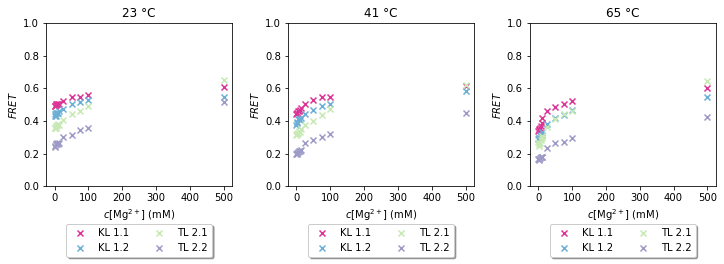

In [43]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), sharex=False, sharey=False, squeeze=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
temps = 21
palette = plt.get_cmap('YlOrRd',temps)
#left  = # the left side of the subplots of the figure
#right = # the right side of the subplots of the figure
#bottom =  # the bottom of the subplots of the figure
#top =  # the top of the subplots of the figure
#wspace = # the amount of width reserved for blank space between subplots
#hspace = # the amount of height reserved for white space between subplots

#range = [-0.1,1] # y achse
ax[0,0].scatter(df_KL1_1_23["concentration (mM)"] , df_KL1_1_23["FRET"], marker="x", color="#dd3497", label='KL 1.1')
ax[0,0].scatter(df_KL1_2_23["concentration (mM)"] , df_KL1_2_23["FRET"], marker="x", color="#6baed6", label='KL 1.2')
ax[0,0].scatter(df_TL2_1_23["concentration (mM)"] , df_TL2_1_23["FRET"], marker="x", color="#c7e9b4", label='TL 2.1')
ax[0,0].scatter(df_TL2_2_23["concentration (mM)"] , df_TL2_2_23["FRET"], marker="x", color="#9e9ac8", label='TL 2.2')
leg = ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, fancybox=True, ncol=2)
ax[0,0].set_title("23 °C")
#ax.set_xlim([180,860])
ax[0,0].set_ylim([0.0,1.0])


ax[0,1].scatter(df_KL1_1_41["concentration (mM)"] , df_KL1_1_41["FRET"], marker="x", color="#dd3497", label='KL 1.1')
ax[0,1].scatter(df_KL1_2_41["concentration (mM)"] , df_KL1_2_41["FRET"], marker="x", color="#6baed6", label='KL 1.2')
ax[0,1].scatter(df_TL2_1_41["concentration (mM)"] , df_TL2_1_41["FRET"], marker="x", color="#c7e9b4", label='TL 2.1')
ax[0,1].scatter(df_TL2_2_41["concentration (mM)"] , df_TL2_2_41["FRET"], marker="x", color="#9e9ac8", label='TL 2.2')
leg = ax[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, fancybox=True, ncol=2)
ax[0,1].set_title("41 °C")
#ax.set_xlim([180,860])
ax[0,1].set_ylim([0.0,1.0])


ax[0,2].scatter(df_KL1_1_65["concentration (mM)"] , df_KL1_1_65["FRET"], marker="x", color="#dd3497", label='KL 1.1')
ax[0,2].scatter(df_KL1_2_65["concentration (mM)"] , df_KL1_2_65["FRET"], marker="x", color="#6baed6", label='KL 1.2')
ax[0,2].scatter(df_TL2_1_65["concentration (mM)"] , df_TL2_1_65["FRET"], marker="x", color="#c7e9b4", label='TL 2.1')
ax[0,2].scatter(df_TL2_2_65["concentration (mM)"] , df_TL2_2_65["FRET"], marker="x", color="#9e9ac8", label='TL 2.2')
leg = ax[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, fancybox=True, ncol=2)
ax[0,2].set_title("65 °C")
#ax[0,0].set_xlim([230,350])
ax[0,2].set_ylim([0.0,1.0])


# set labels
plt.setp(ax[:, :], xlabel='$c$[Mg$^{2+}$] (mM)')
plt.setp(ax[:, :], ylabel='$FRET$')

plt.savefig("2023_05_22_RNA_NaCl_temp_sub.png", dpi=600, bbox_inches="tight")
plt.show()

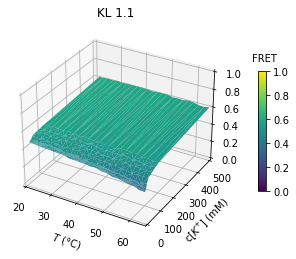

In [44]:
#KL1.1
fig = plt.figure()
#ax = fig.gca(projection='3d') # funktioniert nicht mit neuester matplotlib-version
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(df_KL1_1['temperature (°C)'], df_KL1_1['concentration (mM)'], df_KL1_1['FRET'], cmap=plt.cm.viridis, linewidth=0.1)
plt.colorbar(surf, shrink=0.55, aspect=15,pad = 0.1, location='right').set_label(label='FRET',size=10, labelpad=-25, y=1.15, rotation=0)
surf.set_clim(vmin=0, vmax=1)
ax.set_ylim([0,500])
ax.set_xlim([20,65])
ax.set_zlim([0.0,1.0])
plt.xlabel('$T$ (°C)')
plt.ylabel('c[$K^{+}$] (mM)')
plt.title("KL 1.1")
plt.savefig("2023_05_22_RNA_NaCl_waterfall_KL11.png", dpi=600, bbox_inches="tight")
plt.show()

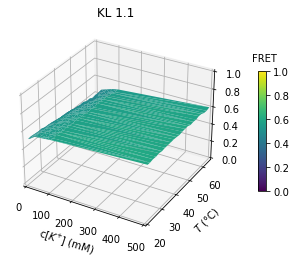

In [45]:
#KL1.1
fig = plt.figure()
#ax = fig.gca(projection='3d') # funktioniert nicht mit neuester matplotlib-version
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(df_KL1_1['concentration (mM)'], df_KL1_1['temperature (°C)'], df_KL1_1['FRET'], cmap=plt.cm.viridis, linewidth=0.1)
plt.colorbar(surf, shrink=0.55, aspect=15,pad = 0.1, location='right').set_label(label='FRET',size=10, labelpad=-25, y=1.15, rotation=0)
surf.set_clim(vmin=0, vmax=1)
ax.set_xlim([0,500])
ax.set_ylim([20,65])
ax.set_zlim([0.0,1.0])
plt.ylabel('$T$ (°C)')
plt.xlabel('c[$K^{+}$] (mM)')
plt.title("KL 1.1")
plt.show()

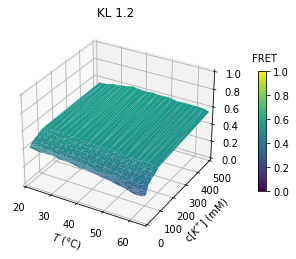

In [46]:
#KL1.2
fig = plt.figure()
#ax = fig.gca(projection='3d') # funktioniert nicht mit neuester matplotlib-version
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(df_KL1_2['temperature (°C)'], df_KL1_2['concentration (mM)'], df_KL1_2['FRET'], cmap=plt.cm.viridis, linewidth=0.1)
plt.colorbar(surf, shrink=0.55, aspect=15,pad = 0.1, location='right').set_label(label='FRET',size=10, labelpad=-25, y=1.15, rotation=0)
surf.set_clim(vmin=0, vmax=1)
ax.set_ylim([0,500])
ax.set_xlim([20,65])
ax.set_zlim([0.0,1.0])
plt.xlabel('$T$ (°C)')
plt.ylabel('c[$K^{+}$] (mM)')
plt.title("KL 1.2")
plt.savefig("2023_05_22_RNA_NaCl_waterfall_KL12.png", dpi=600, bbox_inches="tight")
plt.show()

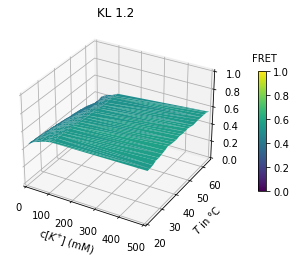

In [47]:
#KL1.2
fig = plt.figure()
#ax = fig.gca(projection='3d') # funktioniert nicht mit neuester matplotlib-version
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(df_KL1_2['concentration (mM)'], df_KL1_2['temperature (°C)'], df_KL1_2['FRET'], cmap=plt.cm.viridis, linewidth=0.1)
plt.colorbar(surf, shrink=0.55, aspect=15,pad = 0.1, location='right').set_label(label='FRET',size=10, labelpad=-25, y=1.15, rotation=0)
surf.set_clim(vmin=0, vmax=1)
ax.set_xlim([0,500])
ax.set_ylim([20,65])
ax.set_zlim([0.0,1.0])
plt.ylabel('$T$ in °C')
plt.xlabel('c[$K^{+}$] (mM)')
plt.title("KL 1.2")
plt.show()

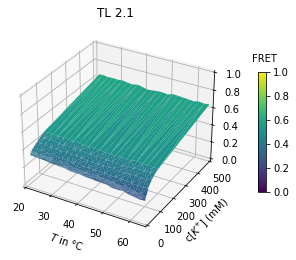

In [48]:
#TL 2.1
fig = plt.figure()
#ax = fig.gca(projection='3d') # funktioniert nicht mit neuester matplotlib-version
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(df_TL2_1['temperature (°C)'], df_TL2_1['concentration (mM)'], df_TL2_1['FRET'], cmap=plt.cm.viridis, linewidth=0.1)
plt.colorbar(surf, shrink=0.55, aspect=15,pad = 0.1, location='right').set_label(label='FRET',size=10, labelpad=-25, y=1.15, rotation=0)
surf.set_clim(vmin=0, vmax=1)
ax.set_ylim([0,500])
ax.set_xlim([20,65])
ax.set_zlim([0.0,1.0])
plt.xlabel('$T$ in °C')
plt.ylabel('c[$K^{+}$] (mM)')
plt.title("TL 2.1")
plt.savefig("2023_05_22_RNA_NaCl_waterfall_TL21.png", dpi=600, bbox_inches="tight")
plt.show()

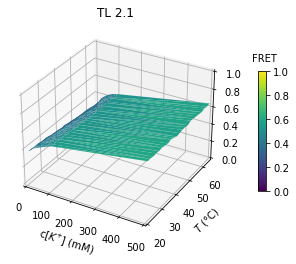

In [49]:
# TL 2.1
fig = plt.figure()
#ax = fig.gca(projection='3d') # funktioniert nicht mit neuester matplotlib-version
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(df_TL2_1['concentration (mM)'], df_TL2_1['temperature (°C)'], df_TL2_1['FRET'], cmap=plt.cm.viridis, linewidth=0.1)
plt.colorbar(surf, shrink=0.55, aspect=15,pad = 0.1, location='right').set_label(label='FRET',size=10, labelpad=-25, y=1.15, rotation=0)
surf.set_clim(vmin=0, vmax=1)
ax.set_xlim([0,500])
ax.set_ylim([20,65])
ax.set_zlim([0.0,1.0])
plt.ylabel('$T$ (°C)')
plt.xlabel('c[$K^{+}$] (mM)')
plt.title("TL 2.1")
plt.show()

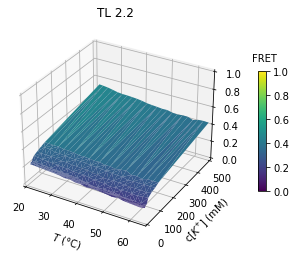

In [50]:
#TL 2.2
fig = plt.figure()
#ax = fig.gca(projection='3d') # funktioniert nicht mit neuester matplotlib-version
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(df_TL2_2['temperature (°C)'], df_TL2_2['concentration (mM)'], df_TL2_2['FRET'], cmap=plt.cm.viridis, linewidth=0.1)
plt.colorbar(surf, shrink=0.55, aspect=15,pad = 0.1, location='right').set_label(label='FRET',size=10, labelpad=-25, y=1.15, rotation=0)
surf.set_clim(vmin=0, vmax=1)
ax.set_ylim([0,500])
ax.set_xlim([20,65])
ax.set_zlim([0.0,1.0])
plt.xlabel('$T$ (°C)')
plt.ylabel('c[$K^{+}$] (mM)')
plt.title("TL 2.2")
plt.savefig("2023_05_22_RNA_NaCl_waterfall_TL22.png", dpi=600, bbox_inches="tight")
plt.show()

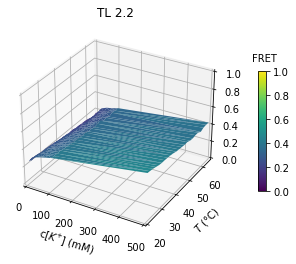

In [51]:
# TL 2.2
fig = plt.figure()
#ax = fig.gca(projection='3d') # funktioniert nicht mit neuester matplotlib-version
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(df_TL2_2['concentration (mM)'], df_TL2_2['temperature (°C)'], df_TL2_2['FRET'], cmap=plt.cm.viridis, linewidth=0.1)
plt.colorbar(surf, shrink=0.55, aspect=15,pad = 0.1, location='right').set_label(label='FRET',size=10, labelpad=-25, y=1.15, rotation=0)
surf.set_clim(vmin=0, vmax=1)
ax.set_xlim([0,500])
ax.set_ylim([20,65])
ax.set_zlim([0.0,1.0])
plt.ylabel('$T$ (°C)')
plt.xlabel('c[$K^{+}$] (mM)')
plt.title("TL 2.2")
plt.show()